# Implementation of MAXSER

### implementation steps(scenario 1)
##### 1. conduct subpool (optional)
##### 2. estimate the square of maximum sharpe ratio by theta_hat in 2.32, and compute the response $\hat{r_c}$ in 2.10
##### 3. select lambda through CV according to 2.5.1, demoted by $\hat{\lambda}$
##### 4. set $\lambda$ in 2.12 to be $\hat{\lambda}$ and solve for the MAXSER portfolio $\hat{\omega^*}$ in 2.12
##### 5. compare with benchmark portfolio 

### Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import yfinance as yf 
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.special as sc
from functools import reduce

##### Some usedul functions

In [4]:
def calculate_sharpe_ratio(risk, returns, risk_free_rate):
    return (returns-risk_free_rate)/risk

def get_max_sharpe_ratio(df):
    return df.ix[df['SharpeRatio'].astype(float).idxmax()]

def get_min_risk(df):
    return df.ix[df['Risk'].astype(float).idxmin()]

def calculate_assets_expectedreturns(returns):        
    return returns.mean() * 252

def calculate_assets_covariance(returns):        
    return returns.cov() * 252
    
def calculate_portfolio_risk(allocations, cov):
    return np.sqrt(reduce(np.dot, [allocations, cov, allocations.T]))

def get_portfolio_return(weights, returns):
    return np.sum(weights * returns)

def get_portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def get_portfolio_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = get_portfolio_return(weights, returns)
    portfolio_volatility = get_portfolio_volatility(weights, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

def select_stock(n_stocks_available, n_stocks):
    np.random.seed(1345) 
    x = np.random.choice(n_stocks_available, n_stocks)
    return x

In [5]:
def mc_simu(meanReturns, covMatrix, mc_sims, T, initialPortfolio):
    weights = np.random.random(len(meanReturns))
    weights /= np.sum(weights)
    
    meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
    meanM = meanM.T

    portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

    for m in range(0, mc_sims):
        # mc loops
        Z = np.random.normal(size=(T, len(weights)))
        L = np.linalg.cholesky(covMatrix)
        dailyReturns = meanM + np.inner(L, Z)
        portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

    portfolio_sims = pd.DataFrame(portfolio_sims)
    return portfolio_sims

### My approach
#### 1. Get companies
#### 2. Get company stock prices
#### 3. Calculate Daily Returns, and Expected Mean Return & Covariance
#### 4. Use Monte Carlo Simulation with expected Mean Return & Covariance
#### 5. Estimate the square of maximum sharpe ratio $\hat{\theta_{adj}}$ 2.32
#### 6. compute $\hat{r_c}$
#### 7. CV for select $\hat{\lambda}$ 2.5.1
#### 8. solve $\hat{\omega}$ for MAXSER in 2.12

### 1. Get companies 2. Get company stock prices
I randomly select 100 stocks from S&P 500. From 2007-01-01 to 2016-12-31.

In [6]:
start_date = "2007-01-01"
end_date = "2016-12-31"
sp500_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'JPM', 'JNJ', 'V', 'PG',
                 'MA', 'NVDA', 'UNH', 'HD', 'VZ', 'DIS', 'PYPL', 'CMCSA', 'BAC', 'CSCO',
                 'INTC', 'T', 'PFE', 'ORCL', 'KO', 'MRK', 'XOM', 'NFLX', 'WMT', 'MCD',
                 'BA', 'TMO', 'CAT', 'ADBE', 'ABBV', 'NKE', 'CRM', 'PEP', 'GS', 'CVX',
                 'PM', 'UPS', 'COST', 'C', 'ABT', 'WFC', 'ACN', 'QCOM', 'AMGN', 'TXN',
                 'NEE', 'DHR', 'SO', 'ADP', 'HON', 'TMO', 'LMT', 'RTX', 'MO', 'MDT',
                 'AMAT', 'CME', 'GD', 'BKNG', 'CSX', 'BIIB', 'COF', 'CVS', 'STZ', 'AXP',
                 'GM', 'LRCX', 'MU', 'MMM', 'USB', 'FDX', 'ISRG', 'CCI', 'EQIX', 'CSX',
                 'SO', 'ADP', 'HON', 'TMO', 'LMT', 'RTX', 'MO', 'MDT', 'AMAT', 'CME',
                 'GD', 'BKNG', 'CSX', 'BIIB', 'COF', 'CVS', 'STZ', 'AXP', 'GM', 'LRCX']
stock_data = {}  # Create a dictionary to store data for each stock

In [7]:
for ticker in sp500_tickers:
    stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [10]:
for ticker, data in stock_data.items():
    data['daily_return'] = data['Adj Close'].pct_change()

### 3. Calculate Daily Returns, and Expected Mean Return & Covariance

In [11]:
returns = np.array(pd.DataFrame(stock_data[ticker]['daily_return'][1:] for ticker in stock_data.keys()))
returns[np.isnan(returns)] = 0

In [12]:
mean = np.mean(returns, axis=1) 
cov = np.cov(returns) 

### 4. Use Monte Carlo Simulation

In [101]:
mc_sims = 10
T = 120 # timeframe in days
initialPortfolio = 1000
N = len(mean)

In [102]:
portfolios_allocations_df = mc_simu(mean, cov, mc_sims, T, initialPortfolio)

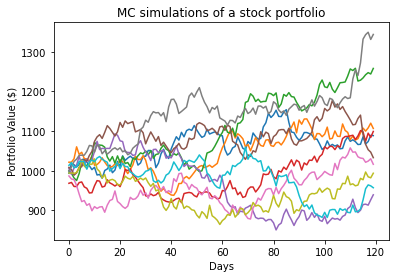

In [103]:
plt.plot(portfolios_allocations_df)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulations of a stock portfolio')
plt.show()

In [104]:
meanReturns = portfolios_allocations_df.pct_change().mean() 
covMatrix = portfolios_allocations_df.pct_change().cov() 

In [105]:
portfolios_allocations_df.pct_change()

,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.025302,0.000249,-0.006492,0.002190,-0.015044,-0.005355,-0.007822,0.009574,-0.000021,0.006943
2,-0.003376,0.008373,-0.011664,-0.010433,0.016396,-0.014193,-0.001532,0.013971,-0.000983,-0.012757
3,-0.005176,0.029145,-0.006609,-0.000130,0.007368,0.006063,-0.015202,0.005691,0.002628,0.001604
4,0.005300,-0.017946,0.017948,0.010323,0.021768,0.014070,-0.022298,0.009325,0.010924,0.013988
...,...,...,...,...,...,...,...,...,...,...
115,0.017623,0.011128,0.004659,-0.003171,0.015806,-0.043432,-0.000933,0.047216,-0.003541,0.025481
116,-0.016631,-0.006886,0.006504,-0.021583,0.001085,-0.022093,-0.009417,0.008350,0.020005,0.030497
117,0.005770,0.007339,0.004230,0.019266,-0.002719,-0.012676,0.002911,0.004569,-0.012161,0.010059
118,0.014560,0.010750,-0.002702,-0.009902,0.014635,-0.005847,0.005772,-0.013426,-0.002586,-0.002492


### 5. Estimate the square of maximum sharpe ratio $\hat{\theta_{adj}}$ 2.32

In [106]:
temp = np.dot(meanReturns, np.linalg.inv(covMatrix))

In [107]:
theta_s = np.dot(temp, meanReturns)

In [109]:
beta = sc.betainc(N/2,(T-N)/2, theta_s/(1+theta_s))*sc.gamma(N/2)*sc.gamma((T-N)/2)/sc.gamma(T/2)

In [110]:
theta_adj_hat = ((T-N-2)*theta_s-N)/T + (2*theta_s**(N/2)*(1+theta_s)**(-(T-2)/2))/(T*beta)

In [111]:
theta_adj_hat

0.0011738310867599466

### 6. compute $\hat{r_c}$

In [112]:
sigma = 0.04

In [113]:
r_c = sigma*(1+theta_adj_hat)/np.sqrt(theta_adj_hat)
print(r_c)

1.168871251666118


### 7. CV for select $\hat{\lambda}$ 2.5.1

### 8. solve $\hat{\omega}$ for MAXSER in 2.12¶

### implementation steps(scenario 2)
##### 1. conduct subpool (optional)
##### 2. Perform OLS regressions of asset returns on factor returns to obtain $\hat{\beta}$ and $\hat{U}$ 
##### 3. Compute the estimates of the square of the maximum Sharpe ratios $\hat{\theta_f}$ , $\hat{\theta_{all,adj}}$ and $\hat{\theta_{u,adj}}$ , and compute the response $\hat{r_c}$ in (2.23);
##### 3. select lambda through CV according to 2.5.1, demoted by $\hat{\lambda}$
##### 4. set $\lambda$ in 2.27 to be $\hat{\lambda}$ and solve for the MAXSER portfolio $\hat{\omega^*_u}$ 
##### 5. Compute $\hat{\omega^*_f}$ and plug in the estimates from the previous steps into (2.30) to obtain the MAXSER portfolio $\hat{\omega_{all}}$
##### 6. compare with benchmark portfolio 

### My approach
#### 1. Get companies
#### 2. Get company stock prices
#### 3. Calculate Daily Returns, and Expected Mean Return & Covariance
#### 4. Calibrate Parameters: Parameters for generating returns are calibrated from S&P 500 and Fama-French 3 factors 
#### 5. Use Monte Carlo Simulation with calibrated Parameters
#### 6. Conduct subpool(optional)
#### 7. Estimate the square of maximum sharpe ratio $\hat{\theta}$ 2.8
#### 8. compute $r_c$
#### 9. CV for select $\hat{\lambda}$
#### 10. solve $\hat{\omega}$ for MAXSER

### 4. Calibrate Parameters: Parameters for generating returns are calibrated from S&P 500 and Fama-French 3 factors

Determine the risk-free rate, this paper use FF3

In [167]:
ff3 = pd.read_csv("ff3_monthly_return.csv")

In [187]:
ff3 = np.transpose(np.array(ff3))[0]